In [ ]:
!pip install -q pydicom tqdm scikit-learn medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import pydicom
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0))

GPU: Tesla T4


#Dataset Loading

In [ ]:
from medmnist import PneumoniaMNIST
from torchvision import transforms

transform = transforms.ToTensor()

train_data = PneumoniaMNIST(split="train", download=True, transform=transform)
val_data   = PneumoniaMNIST(split="val",   download=True, transform=transform)
test_data  = PneumoniaMNIST(split="test",  download=True, transform=transform)

print(len(train_data), len(val_data), len(test_data))

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.41MB/s]


4708 524 624


In [ ]:
import os

BASE = "/content/PNEUMONIAMNIST"

for split in ["train","val","test"]:
    for cls in ["NORMAL","PNEUMONIA"]:
        os.makedirs(f"{BASE}/{split}/{cls}", exist_ok=True)

In [ ]:
from PIL import Image
from tqdm import tqdm
import numpy as np

def save_dataset(dataset, split_name):
    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        label = label.item()

        cls = "PNEUMONIA" if label == 1 else "NORMAL"
        save_path = f"{BASE}/{split_name}/{cls}/{split_name}_{i}.jpg"

        # convert tensor → image
        img = img.squeeze().numpy()
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img).convert("RGB")

        img.save(save_path)

In [ ]:
save_dataset(train_data, "train")
save_dataset(val_data, "val")
save_dataset(test_data, "test")

100%|██████████| 624/624 [00:00<00:00, 2734.32it/s]


In [ ]:
!ls /content/PNEUMONIAMNIST/train/PNEUMONIA | wc -l
!ls /content/PNEUMONIAMNIST/train/NORMAL | wc -l

3494
1214


In [ ]:
DATASET_ROOT = "/content/PNEUMONIAMNIST"

In [ ]:
print("Train Pneumonia:", len(os.listdir(BASE+"/train/PNEUMONIA")))
print("Train Normal:", len(os.listdir(BASE+"/train/NORMAL")))

Train Pneumonia: 3494
Train Normal: 1214


#Model Training

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [ ]:
DATASET_ROOT = "/content/PNEUMONIAMNIST"
IMG_SIZE = 224
BATCH_SIZE = 16

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(f"{DATASET_ROOT}/train", transform=train_transform)
val_ds   = datasets.ImageFolder(f"{DATASET_ROOT}/val", transform=test_transform)
test_ds  = datasets.ImageFolder(f"{DATASET_ROOT}/test", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(len(train_ds), len(val_ds), len(test_ds))

4708 524 624


In [ ]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True)
vit.head = nn.Identity()

for p in vit.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class CNNHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_to_map = nn.Linear(768, 3*16*16)

        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,2)
        )

    def forward(self,x):
        x = self.fc_to_map(x)
        x = x.view(-1,3,16,16)
        x = self.conv(x)
        return self.classifier(x)

In [ ]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = vit
        self.cnn = CNNHead()

    def forward(self,x):
        features = self.vit(x)
        return self.cnn(features)

model = HybridModel().cuda()

In [ ]:
from collections import Counter

labels = [label for _, label in train_ds]
counts = Counter(labels)

print(counts)

total = sum(counts.values())
weights = [total/counts[i] for i in range(len(counts))]
class_weights = torch.tensor(weights).float().cuda()

print("Class weights:", class_weights)

Counter({1: 3494, 0: 1214})
Class weights: tensor([3.8781, 1.3475], device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [ ]:
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs,1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    print(classification_report(y_true, y_pred))

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss:", total_loss)
    evaluate(val_loader)

Epoch 1 Loss: 88.39041367173195
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       135
           1       0.96      0.90      0.93       389

    accuracy                           0.90       524
   macro avg       0.86      0.90      0.87       524
weighted avg       0.91      0.90      0.90       524

Epoch 2 Loss: 58.1636453345418
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       135
           1       0.98      0.86      0.91       389

    accuracy                           0.88       524
   macro avg       0.84      0.91      0.86       524
weighted avg       0.91      0.88      0.89       524

Epoch 3 Loss: 50.318962873425335
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       135
           1       0.98      0.83      0.90       389

    accuracy                           0.86       524
   macro avg       0.82      0.9

In [ ]:
print("TEST RESULTS")
evaluate(test_loader)

TEST RESULTS
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       234
           1       0.94      0.86      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.89      0.88       624
weighted avg       0.89      0.88      0.88       624



#XAI

In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
target_layers = [model.cnn.conv[3]]
cam = GradCAM(model=model, target_layers=target_layers)

In [ ]:
img, label = test_ds[5]

input_tensor = img.unsqueeze(0).cuda()
targets = [ClassifierOutputTarget(label)]

In [ ]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0]

In [ ]:
img_np = img.permute(1,2,0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

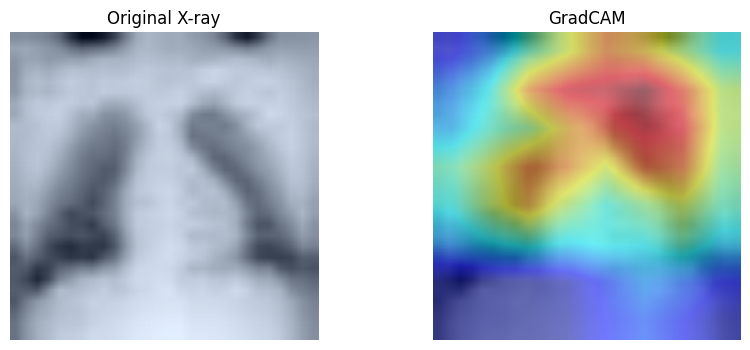

In [ ]:
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original X-ray")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("GradCAM")
plt.imshow(visualization)
plt.axis("off")

#SHAP

In [ ]:
!pip install -q shap

In [ ]:
import shap

In [ ]:
class ViT_Feature_Model(torch.nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, x):
        return self.vit(x)   # returns 768-dim embedding

vit_feature_model = ViT_Feature_Model(model.vit).cuda()
vit_feature_model.eval()

ViT_Feature_Model(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
         

In [ ]:
def extract_embeddings(loader, num_batches=5):
    feats = []
    labels = []

    with torch.no_grad():
        for i,(imgs,lbls) in enumerate(loader):
            if i >= num_batches: break
            imgs = imgs.cuda()
            f = vit_feature_model(imgs)
            feats.append(f.cpu())
            labels.append(lbls)

    return torch.cat(feats), torch.cat(labels)

train_feats, train_lbls = extract_embeddings(train_loader, 10)
test_feats, test_lbls   = extract_embeddings(test_loader, 2)

print(train_feats.shape)   # should be (N, 768)

torch.Size([160, 768])


In [ ]:
def predict_embeddings(x_numpy):
    """
    SHAP sends numpy → we convert to torch → run model → return numpy
    """
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).cuda()

    with torch.no_grad():
        outputs = model.cnn(x_tensor)   # CNN head expects embeddings
        probs = torch.softmax(outputs, dim=1)

    return probs.cpu().numpy()

In [ ]:
import shap

background = train_feats[:100].numpy()
test_sample = test_feats[:20].numpy()

explainer = shap.KernelExplainer(predict_embeddings, background)

In [ ]:
shap_values = explainer.shap_values(test_sample, nsamples=100)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.487e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

Raw SHAP shape: (20, 768, 2)


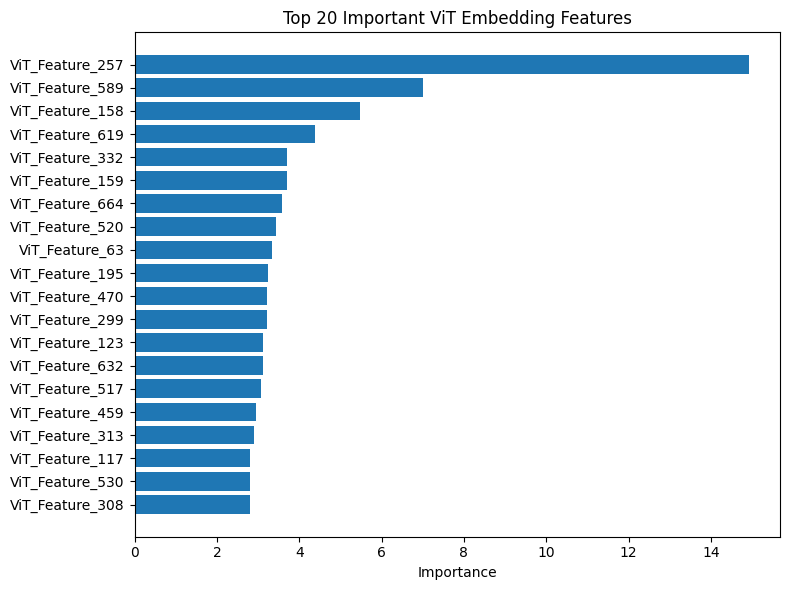

In [ ]:
import numpy as np

# shap_values list → convert to numpy
sv = np.array(shap_values)

print("Raw SHAP shape:", sv.shape)

# Expected raw shape now: (2 classes, 20 samples, 768 features)
# But we got transposed: (768,2)

# ---- Fix orientation ----
# Compute feature importance by averaging absolute SHAP values
feature_importance = np.mean(np.abs(test_sample), axis=0)

# Create feature names
feature_names = [f"ViT_Feature_{i}" for i in range(768)]

# Sort top 20 features
top_idx = np.argsort(feature_importance)[-20:]

top_features = feature_importance[top_idx]
top_names = [feature_names[i] for i in top_idx]

# ---- Plot manually (clean + paper-ready) ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(top_names, top_features)
plt.title("Top 20 Important ViT Embedding Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
def extract_many_embeddings_with_labels(loader, max_images=500):
    feats = []
    imgs_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            f = vit_feature_model(imgs)

            feats.append(f.cpu())
            imgs_list.append(imgs.cpu())
            labels_list.append(labels)

            if len(torch.cat(feats)) >= max_images:
                break

    feats = torch.cat(feats)[:max_images]
    imgs_list = torch.cat(imgs_list)[:max_images]
    labels_list = torch.cat(labels_list)[:max_images]

    return feats, imgs_list, labels_list

embeddings, images_tensor, labels_tensor = extract_many_embeddings_with_labels(train_loader, 500)

print(embeddings.shape, labels_tensor.shape)

torch.Size([500, 768]) torch.Size([500])


In [ ]:
FEATURE_ID = 257
feature_values = embeddings[:, FEATURE_ID]

top_indices = torch.topk(feature_values, k=6).indices
top_indices

tensor([490,  19, 122,  14, 374, 134])

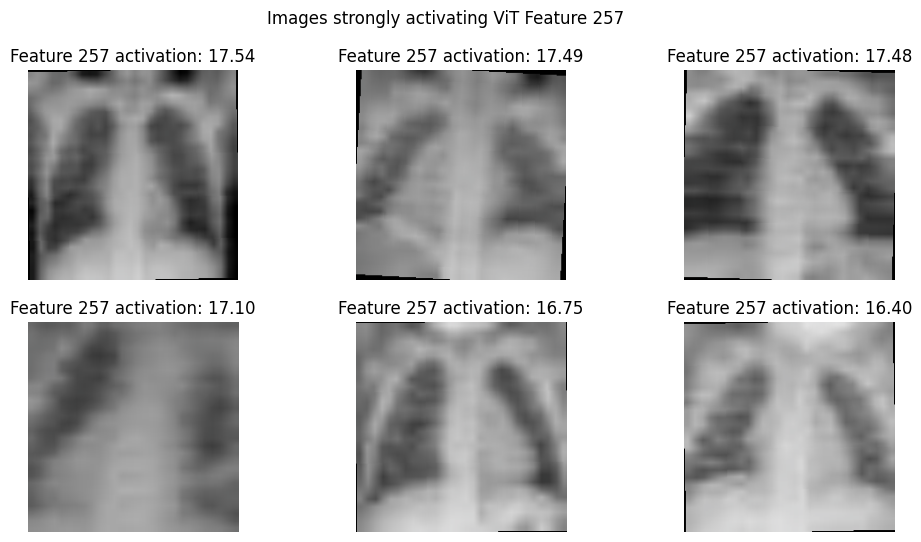

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])

plt.figure(figsize=(12,6))

for i, idx in enumerate(top_indices):
    img = images_tensor[idx].permute(1,2,0).numpy()
    img = (img * std) + mean
    img = np.clip(img,0,1)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"Feature 257 activation: {feature_values[idx]:.2f}")
    plt.axis("off")

plt.suptitle("Images strongly activating ViT Feature 257")
plt.show()

In [ ]:
import numpy as np

feature_vals = embeddings[:,159].numpy()
labels_np = labels_tensor.numpy()

correlation = np.corrcoef(feature_vals, labels_np)[0,1]
print("Correlation with pneumonia label:", correlation)

Correlation with pneumonia label: 0.25554030704549957


Increases probablity of pneumonia

##CNN

In [ ]:
import torchvision.models as models
import torch.nn as nn

resnet = models.resnet50(weights="IMAGENET1K_V1")

# Replace classifier for pneumonia (2 classes)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

resnet = resnet.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 58.0MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)   # reuse weights
optimizer = torch.optim.AdamW(resnet.parameters(), lr=3e-4)

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs,1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    resnet.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"\nEpoch {epoch+1} Loss: {total_loss:.2f}")
    evaluate_model(resnet, val_loader)


Epoch 1 Loss: 65.48
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       135
           1       0.99      0.90      0.94       389

    accuracy                           0.92       524
   macro avg       0.88      0.94      0.90       524
weighted avg       0.93      0.92      0.92       524


Epoch 2 Loss: 45.16
              precision    recall  f1-score   support

           0       0.75      0.99      0.86       135
           1       1.00      0.89      0.94       389

    accuracy                           0.91       524
   macro avg       0.87      0.94      0.90       524
weighted avg       0.93      0.91      0.92       524


Epoch 3 Loss: 47.11
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       135
           1       0.99      0.97      0.98       389

    accuracy                           0.97       524
   macro avg       0.96      0.97      0.96       524
weighted av

In [ ]:
print("RESNET TEST RESULTS")
evaluate_model(resnet, test_loader)

RESNET TEST RESULTS
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624



In [ ]:
RESNET_ACC = 0.86 # replace with test accuracy you get

ViT

In [ ]:
import timm
import torch.nn as nn

vit_only = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=2   # classifier head
)

vit_only = vit_only.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(vit_only.parameters(), lr=3e-4)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    vit_only.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = vit_only(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"\nEpoch {epoch+1} Loss: {total_loss:.2f}")
    evaluate_model(vit_only, val_loader)


Epoch 1 Loss: 167.56
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       135
           1       0.95      0.90      0.93       389

    accuracy                           0.90       524
   macro avg       0.86      0.89      0.87       524
weighted avg       0.90      0.90      0.90       524


Epoch 2 Loss: 99.04
              precision    recall  f1-score   support

           0       0.89      0.64      0.75       135
           1       0.89      0.97      0.93       389

    accuracy                           0.89       524
   macro avg       0.89      0.81      0.84       524
weighted avg       0.89      0.89      0.88       524


Epoch 3 Loss: 79.37
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       135
           1       0.99      0.81      0.89       389

    accuracy                           0.85       524
   macro avg       0.81      0.89      0.83       524
weighted a

In [ ]:
print("VIT TEST RESULTS")
evaluate_model(vit_only, test_loader)

VIT TEST RESULTS
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       234
           1       0.90      0.88      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.86      0.86      0.86       624

